### This notebook demonstrates how we combine surrogate and subgraph density difference for frequency band personalization
Below creates $\Delta D$ vs $f$ curves of Fig. 4 in our submitted IJNS draft, "Frequency Band Personalization for Seizure Network Analysis in
Multifocal Patients"

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from scipy.signal import hilbert, fftconvolve
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
import seaborn as sns  # For better-looking heatmaps (optional)
from joblib import Parallel, delayed
import time
import networkx as nx


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
Fs = 1000
## in utd computer, de
sz_sample = [r"C:\Users\Patient_2000\20_PV_1999_2099.csv"]


## Channel selection is based on LDA ranking, which can be referred to our previous works.
notable_channels = ['LA1','LA2','LB1','LB2','LB5','LB6','LC1','LC2','LC5','LC6',
                    'RA1','RA2','RB1','RB2','RB5','RB6','RC1','RC2','RC5','RC6']

#notable_channels = ['LC7','LC8','LT1','LT2','LU1','LU2','LU7','LU8','RA5','RA6','RA7','RB1',
                   #'RB2','RB6','RB7','RB8','RC1','RC2','RI1','RI2']
Left_channels = [name for name in notable_channels if name.startswith("L")]
Right_channels = [name for name in notable_channels if name.startswith("R")]

num_channel = int(len(notable_channels))

In [3]:
def Data_split(input_df, Timesize,overlap):  # Timesize in Sec.,
    win_size = Timesize * Fs
    #raw_SEEG = input_df.drop(channel_irrelevant, axis=1)
    raw_SEEG = input_df.loc[:,notable_channels]

    if overlap == 50:
        num_epoch = int(2*raw_SEEG.shape[0] /win_size-1)
        effect_size = int(win_size/2)
    else:
        num_epoch = raw_SEEG.shape[0] / win_size  # default non-lapping
        effect_size = win_size

    df_series = []
    count = 0
    while True:
        if count > num_epoch:
            break

        df_series.append(raw_SEEG.iloc[count*effect_size:count*effect_size+win_size])
        count += 1

    return df_series,count

sz_data_path = sz_sample[0]  ### simply for this case
sz_data = pd.read_csv(sz_data_path)
rns_labels = ['LB1', 'LB2', 'LC1']

sz_series, frame_count = Data_split(input_df=sz_data, Timesize=2, overlap=50)


model_order = 10
freq_band_dict = {'theta': (4, 9), 'alpha': (9, 13), 'beta': (13, 30), 'gamma': (30, 55)}

In [4]:
def compute_dtf(data, model_order=10, f_sample=Fs, freq_range=(8, 55), n_freqs=128, transpose_output=True):
    """
    Compute frequency-resolved DTF from multivariate time series.

    Parameters:
        data: np.ndarray, shape (n_samples, n_channels)
        model_order: int
        f_sample: float, sampling frequency in Hz
        freq_band: tuple (f_min, f_max)
        n_freqs: int, number of frequencies to evaluate !! this is used to divide the selected range into n_freq points, for 
        transpose_output: bool, if True returns shape (channels, channels, freqs)

    Returns:
        H_normalized: np.ndarray, shape (freqs, ch, ch) or (ch, ch, freqs)
        freqs: np.ndarray, evaluated frequency points
    """
    # Fit MVAR model using statsmodels
    var_model = VAR(data)
    results = var_model.fit(model_order)

    # Coefficients of the MVAR model
    #A_list = np.array([results.coefs[i] for i in range(model_order)])  # Shape: (model_order, num_channel, num_channel)
    A_list = results.coefs
    # Frequency range 
    f_min, f_max = freq_range
    freqs = np.linspace(f_min, f_max, n_freqs)  # Higher resolution for integration
    omega = 2 * np.pi * freqs / f_sample  # Angular frequencies

    # Precompute terms for all frequencies and lags
    exp_omega_lag = np.exp(-1j * omega[:, None] * np.arange(1, model_order + 1))  # Shape: (num_freqs, model_order)
    sum_term = np.einsum('fk,kij->fij', exp_omega_lag, A_list)  # (n_freqs, ch, ch)
    H = np.eye(num_channel, dtype=np.complex128)[None, :, :] - sum_term
    # Compute the inverse of H for all frequencies
    H_inv = np.linalg.inv(H)  # Shape: (num_freqs, num_channel, num_channel)

    # Compute the absolute squared values of H_inv
    H_abs2 = np.abs(H_inv) ** 2  # Shape: (num_freqs, num_channel, num_channel)
    H_abs2 = H_abs2.astype(np.float32)
    # Normalize H_abs2 row-wise for all frequencies
    H_norm = np.sum(H_abs2, axis=2, keepdims=True) + + 1e-10 # Shape: (num_freqs, num_channel, 1)
    H_normalized = H_abs2 / H_norm  # Shape: (num_freqs, num_channel, num_channel)

    if transpose_output:
        H_normalized = np.transpose(H_normalized, (1, 2, 0)) # ch, ch, freq
    return H_normalized, freqs


In [5]:
def extract_dtf_series(series_list, model_order=10, f_sample=Fs, freq_range=(8, 55), n_freqs=128):
    """
    Compute DTF for each time window in a series.

    Args:
        series_list: list of arrays, each (window_samples, channels)
        model_order, f_sample, freq_range, n_freqs: as in compute_dtf

    Returns:
        dtf_list: list of np.ndarrays, each (channels, channels, freqs)
    """
    dtf_list = []

    for i, window in enumerate(series_list):
        try:
            dtf, _ = compute_dtf(window, model_order=model_order, f_sample=f_sample,
                                 freq_range=freq_range, n_freqs=n_freqs, transpose_output=True)
            dtf_list.append(dtf)
        except Exception as e:
            print(f"Skipping window {i} due to DTF failure: {e}")
            continue

    return dtf_list


In [6]:
def phase_randomize_df(df, seed=None):
    """
    Phase-randomize each column (channel) of a DataFrame.
    Returns a new DataFrame with same shape and columns.
    """
    if seed is not None:
        np.random.seed(seed)

    n_samples = df.shape[0]
    surr_data = np.zeros_like(df.values, dtype=np.float64)

    for i, col in enumerate(df.columns):
        x = df[col].values
        Xf = np.fft.rfft(x)
        mag = np.abs(Xf)
        phase = np.angle(Xf)

        # Randomize phase (preserve DC and Nyquist)
        rand_phase = np.random.uniform(0, 2 * np.pi, len(phase))
        rand_phase[0] = 0
        if n_samples % 2 == 0:
            rand_phase[-1] = 0

        Xf_surr = mag * np.exp(1j * rand_phase)
        x_surr = np.fft.irfft(Xf_surr, n=n_samples)
        surr_data[:, i] = x_surr

    return pd.DataFrame(surr_data, columns=notable_channels, index=df.index)

In [7]:
def surrogate_per_frame(frame_df, freq_range=(8, 80), n_freqs=128, model_order=10, seed=None):
    surr_df = phase_randomize_df(frame_df, seed=seed)
    data = surr_df.values  # shape: (samples, channels)
    dtf, _ = compute_dtf(data, model_order=model_order, f_sample=1000,
                         freq_range=freq_range, n_freqs=n_freqs)
    return dtf  # shape: (ch, ch, freq)


In [8]:
def compute_surrogate_set(frame_list, n_jobs=-1, **kwargs):
    import time
    def timed_frame(frame, idx):
        start = time.time()
        result = surrogate_per_frame(frame, **kwargs)
        elapsed = time.time() - start
        print(f"  Frame {idx}: {elapsed:.2f} s")
        return result
        
    return Parallel(n_jobs=n_jobs)(
        delayed(timed_frame)(frame, idx)
        for idx, frame in enumerate(frame_list)
    )

In [9]:
def threshold_dtf_real_vs_surrogate(real_dtf, surr_dtf_list, percentile=95):
    """
    Apply significance mask to real DTF using surrogate distribution.

    Args:
        real_dtf: np.ndarray, shape (ch, ch, freq)
        surr_dtf_list: list of np.ndarrays, shape (ch, ch, freq)
        percentile: significance threshold

    Returns:
        significant_dtf: np.ndarray, masked version of real_dtf
    """
    surr_stack = np.stack(surr_dtf_list, axis=0)  # shape: (n_surr, ch, ch, freq)
    thresholds = np.percentile(surr_stack, percentile, axis=0)  # shape: (ch, ch, freq)

    significant_mask = real_dtf > thresholds
    return real_dtf * significant_mask.astype(np.float32)

In [10]:
def process_dtf_with_surrogates(series_list, n_surrogates=200,
                                 freq_range=(8, 80), n_freqs=128,
                                 model_order=10, f_sample=1000,
                                 p_value=0.01, n_jobs=-1):
    """
    Compute significant DTF matrices for a list of time windows,
    using surrogate analysis and p-value thresholding.

    Returns:
        dtf_significant: np.ndarray, shape (frames, ch, ch, freqs)
    """
    real_dtf_list = []
    surr_dtf_list_per_frame = []

    for idx, frame_df in enumerate(series_list):
        ##print(f"\nProcessing frame {idx + 1}/{len(series_list)}")

        try:
            # Step 1: Real DTF
            real_dtf, _ = compute_dtf(frame_df.values, model_order=model_order,
                                      f_sample=f_sample, freq_range=freq_range,
                                      n_freqs=n_freqs, transpose_output=True)
            real_dtf_list.append(real_dtf)
        except Exception as e:
            print(f"  Skipped (real DTF error): {e}")
            continue

        try:
            # Step 2: Surrogate DTFs for this frame
            surr_dtf_list = compute_surrogate_set(
                [frame_df] * n_surrogates,
                freq_range=freq_range,
                n_freqs=n_freqs,
                model_order=model_order,
                seed=idx,
                n_jobs=n_jobs
            )
            surr_dtf_list_per_frame.append(np.stack(surr_dtf_list, axis=0))  # shape: (n_surrogates, ch, ch, freqs)
        except Exception as e:
            print(f"  Skipped (surrogate error): {e}")
            real_dtf_list.pop()
            continue

    # Step 3: Stack all real and surrogate DTFs
    print(f"[DEBUG] # real frames processed: {len(real_dtf_list)}")
    print(f"[DEBUG] current file/frame list length: {len(series_list)}")
    dtf_real = np.stack(real_dtf_list, axis=0)  # shape: (frames, ch, ch, freqs)
    dtf_surr = np.stack(surr_dtf_list_per_frame, axis=0)  # shape: (frames, n_surrogates, ch, ch, freqs)

    # Step 4: Compute p-threshold from surrogate and mask
    thresholds = np.percentile(dtf_surr, 100 * (1 - p_value), axis=1)  # shape: (frames, ch, ch, freqs)
    significant_mask = (dtf_real > thresholds).astype(np.uint8)
    dtf_significant = dtf_real * significant_mask

    return dtf_significant  # shape: (frames, ch, ch, freqs)


start_time = time.time()
sz_dtf_sig = process_dtf_with_surrogates(sz_series, n_surrogates=200)
#nonsz_dtf_sig = process_dtf_with_surrogates(nonsz_series, n_surrogates=200)
end_time = time.time()
print(f"\nTotal surrogate processing time: {end_time - start_time:.2f} seconds")

[DEBUG] # real frames processed: 250
[DEBUG] current file/frame list length: 250

Total surrogate processing time: 323.18 seconds


In [11]:
def compute_subgraph_density(dtf_significant, subgraph_indices):
    """
    Compute frequency-wise DTF density averaged over time for a given subgraph.

    Args:
        dtf_significant: np.ndarray, shape (frames, channels, channels, frequencies)
        subgraph_indices: list of int, indices of nodes in subgraph

    Returns:
        sub_density: np.ndarray, shape (freq,)
        non_sub_density: np.ndarray, shape (freq,)
        contrast: np.ndarray, shape (freq,)
    """
    # Average over time
    dtf_avg = np.mean(dtf_significant, axis=0)  # shape: (ch, ch, freq)

    n_channels, _, n_freqs = dtf_avg.shape  ## Jul 8, why n_freqs is always 64?? now I adjusted to 128
    all_indices = set(range(n_channels))
    sub_indices = set(subgraph_indices)
    non_sub_indices = list(all_indices - sub_indices)

    sub_density = np.zeros(n_freqs)
    non_sub_density = np.zeros(n_freqs)

    for f in range(n_freqs):
        mat = dtf_avg[:, :, f]

        # Subgraph edges
        sub_edges = [mat[i, j] for i in subgraph_indices for j in subgraph_indices if i != j]
        sub_density[f] = np.mean(sub_edges) if sub_edges else 0

        # Non-subgraph edges
        non_edges = [mat[i, j] for i in non_sub_indices for j in non_sub_indices if i != j]
        non_sub_density[f] = np.mean(non_edges) if non_edges else 0

    contrast = sub_density - non_sub_density
    return sub_density, non_sub_density, contrast


rns_indices = [notable_channels.index(ch) for ch in rns_labels]

rns_density, nonrns_density, contrast = compute_subgraph_density(dtf_significant=sz_dtf_sig, subgraph_indices=rns_indices)
print(len(rns_density))

128


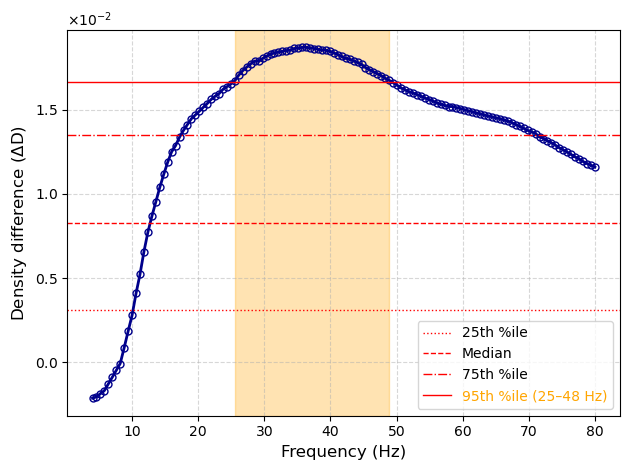

In [12]:
Dmin = np.min(contrast)
Dmax = np.max(contrast)
# print(len(contrast)) = 128, which is the freq_bins

# Evenly spaced thresholds over the continuous range
d_25 = Dmin + 0.25 * (Dmax - Dmin)
d_50 = Dmin + 0.50 * (Dmax - Dmin)
d_75 = Dmin + 0.75 * (Dmax - Dmin)
d_95 = Dmin + 0.90 * (Dmax - Dmin)

# Count how many values fall in each band (optional insight)
in_0_25 = np.sum((contrast >= Dmin) & (contrast < d_25))
in_25_50 = np.sum((contrast >= d_25) & (contrast < d_50))
in_50_75 = np.sum((contrast >= d_50) & (contrast < d_75))
in_75_100 = np.sum((contrast >= d_75) & (contrast <= Dmax))

# Find indices where mask changes (False → True or True → False)
mask_top = contrast > d_95
mask_diff = np.diff(mask_top.astype(int))

# Start points: where it goes False → True
start_idxs = np.where(mask_diff == 1)[0] + 1
# End points: where it goes True → False
end_idxs   = np.where(mask_diff == -1)[0] + 1

# Handle edge cases: if it starts or ends in a True block
if mask_top[0]:
    start_idxs = np.r_[0, start_idxs]
if mask_top[-1]:
    end_idxs = np.r_[end_idxs, len(mask_top)]

freqs = np.linspace(4, 80, 128)  # Now freqs has same length as contrast
plt.plot(freqs, contrast, color='darkblue', linewidth=2,marker='o', markersize=5, markevery=1, markerfacecolor='none')
# Highlight top bands
#for start, end in mask_top:
'''
for start, end in zip(start_idxs, end_idxs):
    s = int(start)
    e = int(end)
    freq_lower = int(freqs[s])
    freq_upper = int(freqs[e])
    label = f"({freq_lower}–{freq_upper} Hz)"
    plt.axvspan(freqs[s], freqs[e-1], color='orange', alpha=0.3)#, label=label)
    #plt.axvline(freqs[s], color='or', linestyle='--', linewidth=1)
    # plt.axvline(freqs[e-1], color='green', linestyle='--', linewidth=1)
#print(highlighted_bands)
'''
# Add percentile reference lines
#freqs = np.arange(8, 80)


for start, end in zip(start_idxs, end_idxs):
    s = int(start)
    e = int(end)
    freq_lower = int(freqs[s])
    freq_upper = int(freqs[e-1])
    label = f"({freq_lower}–{freq_upper} Hz)"
    plt.axvspan(freqs[s], freqs[e-1], color='orange', alpha=0.3)#, label=label)
    #plt.axvline(freqs[s], color='or', linestyle='--', linewidth=1)
    # plt.axvline(freqs[e-1], color='green', linestyle='--', linewidth=1)
#print(highlighted_bands)

plt.axhline(d_25, linestyle=':', color='red', linewidth=1, label='25th %ile')
plt.axhline(d_50, linestyle='--', color='red', linewidth=1, label='Median')
plt.axhline(d_75, linestyle='-.', color='red', linewidth=1, label='75th %ile')
band_label = f"({freq_lower}–{freq_upper} Hz)"
plt.axhline(d_95, linestyle='-', color='red', linewidth=1, label='95th %ile'+' '+label)
# --- Axes labels ---

from matplotlib.ticker import ScalarFormatter 

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))   # same effect as scilimits=(-2,2)
plt.gca().yaxis.set_major_formatter(formatter)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))

# Optional: make the 10^x offset label a bit larger
plt.gca().yaxis.get_offset_text().set_fontsize(10)
legend = plt.legend()
legend_texts = legend.get_texts()
legend_texts[-1].set_color("orange")


# --- Continue with grid, legend, etc. ---




plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Density difference ($\Delta$D)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("./figures/curves/test.svg", dpi=300, bbox_inches='tight')
#plt.ticklabel_format(axis='y', style='sci', scilimits=(-4, 0))
plt.show()